# Coffee Tourism with the Foresquare API
## Capstone Project for IBM Data Science Course ##
### Jim Cser, July 2020 ###

## Introduction  ##
Coffee is the world's greatest beverage, and I want to spread the good word. I live in New York City, and I intend to start a business specializing in Coffee Tourism Tours. I can only run a few tours at first, so I need to find the best neighborhoods in which to locate them. Furthermore I want to choose the best coffee places, so I will take into account the venue ratings, not just the number of venues.  This analysis will begin will only search neighborhoods in Brooklyn.

### Import relevant Python libraries ###

### First step is to get the centroids for each of the NYC neighborhoods in Brooklyn ###

#### Source:  Neighborhood Tabulation Areas (NTA)- New York City Open Data ####
https://data.cityofnewyork.us/City-Government/Neighborhood-Tabulation-Areas-NTA-/cpf4-rkhq

In [87]:
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize

In [88]:
# read in data
df_nyc = pd.read_csv('https://data.cityofnewyork.us/api/views/xyye-rtrs/rows.csv')[['the_geom','Name','Borough']]
df_nyc = df_nyc.loc[df_nyc['Borough'] == 'Brooklyn']
df_nyc.head()


,the_geom,Name,Borough
46,POINT (-74.03062069353821 40.62580106501069),Bay Ridge,Brooklyn
47,POINT (-73.99517998380736 40.61100890202048),Bensonhurst,Brooklyn
48,POINT (-74.01031618527792 40.64510294925433),Sunset Park,Brooklyn
49,POINT (-73.954240931274 40.730200984864744),Greenpoint,Brooklyn
50,POINT (-73.97347087708452 40.59526001306597),Gravesend,Brooklyn


### The column contaning the coordinates for each borough needs to be parsed to extract the latitude and longitude.  We define a function to perform the required string operation on the 'the_geom' column, then apply that function over all the rows ###

In [89]:

# define function to parse geometry column
def split_name(name):
    geom = name[7:-1]
    lng,lat = geom.split()
    return pd.Series({
        'lat': lat,
        'lng': lng
    })

# df_new has the new columns
df_new = df_nyc['the_geom'].apply(split_name)

nyc_latlng = pd.concat([df_nyc,df_new],axis=1)
nyc_latlng.drop("the_geom", axis = 1, inplace = True)

# change lat, lng columns to type float
nyc_latlng[['lat','lng']] = nyc_latlng[['lat','lng']].astype('float')
nyc_latlng = pd.DataFrame(nyc_latlng)
#nyc_latlng = nyc_latlng.set_index('Name')
nyc_latlng.head()


,Name,Borough,lat,lng
46,Bay Ridge,Brooklyn,40.625801,-74.030621
47,Bensonhurst,Brooklyn,40.611009,-73.995180
48,Sunset Park,Brooklyn,40.645103,-74.010316
49,Greenpoint,Brooklyn,40.730201,-73.954241
50,Gravesend,Brooklyn,40.595260,-73.973471


### Next, let's look at the data we can download from Foursquare, and search for venues which serve coffee: ###

#### As an example, we will choose the 'Dumbo' Neighborhood in Brooklyn, and search within 200 meters of each neighborhood centroid: ###


In [90]:
neighborhood = 'Dumbo'
latitude = 40.703176
longitude = -73.988753

search_query = 'coffee'
radius = 200
CLIENT_ID = 'L2GRGZBNAVVZ4QC53S1TRRYU2DFSJKBK4UR0BNDY0QODGN5K' # your Foursquare ID
CLIENT_SECRET = 'WNYRNNV0TSIMSQET1DGFC3DF40DBHN1NBIS0OCJH50YQ1LYU' # your Foursquare Secret
VERSION = '20180604'

LIMIT = 100

url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)


#### Each of the parameters is appended to a URL to create the API request that is sent to the Foursquare server.  The returned data is a list of venues in JSON format, and converted into a Pandas data frame: ####

In [91]:
import requests # library to handle requests
results = requests.get(url).json()
venues = results['response']['venues']
# tranform venues into a dataframe
df_venues_raw = json_normalize(venues)
df_venues_raw.head()

,categories,hasPerk,id,location.address,location.cc,location.city,location.country,location.crossStreet,location.distance,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.postalCode,location.state,name,referralId,venuePage.id
0,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",False,5b19dc1e628c83002cacca4d,147 Front St,US,Brooklyn,United States,pearl,151,"[147 Front St (pearl), Brooklyn, NY 11201, Uni...","[{'label': 'display', 'lat': 40.70273245188341...",40.702732,-73.987051,11201,NY,Ludwig Coffee®,v-1595121040,496940195
1,"[{'id': '4bf58dd8d48988d117951735', 'name': 'C...",False,4db0a697fc60cfe27fb4b875,147 Front St,US,Brooklyn,United States,Jay Street,156,"[147 Front St (Jay Street), Brooklyn, NY 11201...","[{'label': 'display', 'lat': 40.70252227783203...",40.702522,-73.987106,11201,NY,RITTER SPORT @the coffee box,v-1595121040,NaN
2,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",False,49e4a677f964a52014631fe3,67 Front St,US,Brooklyn,United States,at Main St,189,"[67 Front St (at Main St), Brooklyn, NY 11201,...","[{'label': 'display', 'lat': 40.702694, 'lng':...",40.702694,-73.990906,11201,NY,Starbucks,v-1595121040,NaN
3,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",False,4dcc5861887714552bd47b34,25 Jay St,US,Brooklyn,United States,btwn Plymouth & John St,215,"[25 Jay St (btwn Plymouth & John St), Brooklyn...","[{'label': 'display', 'lat': 40.70421760808286...",40.704218,-73.986597,11201,NY,Brooklyn Roasting Company,v-1595121040,48722666


#### For the returned table, expand the lists contained in the 'category' fields, and select only a subset of the columns: ####

In [92]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['id','name', 'categories', 'location.lat', 'location.lng']
df_venues = df_venues_raw.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
df_venues['categories'] = df_venues.apply(get_category_type, axis=1)

# clean column names by keeping only last term
df_venues.columns = [column.split('.')[-1] for column in df_venues.columns]

df_venues.head()

,id,name,categories,lat,lng
0,5b19dc1e628c83002cacca4d,Ludwig Coffee®,Coffee Shop,40.702732,-73.987051
1,4db0a697fc60cfe27fb4b875,RITTER SPORT @the coffee box,Candy Store,40.702522,-73.987106
2,49e4a677f964a52014631fe3,Starbucks,Coffee Shop,40.702694,-73.990906
3,4dcc5861887714552bd47b34,Brooklyn Roasting Company,Coffee Shop,40.704218,-73.986597


#### Since we only want the best coffee for the people on our tour,  just taking the count of all the coffee venues is not enough. -- we want to know their ratings.  So now, we write another Foursquare API request for venue ratings, loop though all the coffee venues, and take the mean of all those who had a rating.  For the Dumbo Neighborhood, we get an average rating of 7.6 ####

In [93]:
# now let's loop through venues for the neighborhood:
id_list = df_venues['id']
rating_list = []
for ven_id in id_list:   
        try:
            url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(ven_id, CLIENT_ID, CLIENT_SECRET, VERSION)
            results = requests.get(url).json()
            rating = results['response']['venue']['rating']
        except:
            rating = 0
           
        rating_list.append(rating)

df_venues['rating'] = rating_list

# get mean rating where rating > 0
avg_rating = df_venues[df_venues['rating'] > 0]['rating'].mean(axis=0)
if pd.isnull(avg_rating):
    avg_rating = 0
    
round(avg_rating,3)

7.6

### Let's put it all together, and calculate the average ratings for each neighborhood, where there is no data the result is set to zero. ###

In [94]:
search_query = 'coffee'
radius = 500

neighbor_ratings = nyc_latlng.copy()
neighbor_ratings = neighbor_ratings


avg_nh_rating = []

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# Loop through neighborhoods  (this should really be a vector operation, though)
i = 0

for nh in neighbor_ratings.index.values:
    latitude = neighbor_ratings.loc[nh,'lat']
    longitude = neighbor_ratings.loc[nh,'lng']


    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
    
    try:
        results = requests.get(url).json()
        venues = results['response']['venues']
        df_venues = json_normalize(venues)
    except:
        df_venues = []
        
        
    if len(df_venues) == 0:
        avg_rating = 0
        
    elif df_venues.shape[0] == 0:
        avg_rating = 0
    
    else:    
        id_list = df_venues['id']
        
        rating_list = []
        for ven_id in id_list:   
            try:
                url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(ven_id, CLIENT_ID, CLIENT_SECRET, VERSION)
                results = requests.get(url).json()
                rating = results['response']['venue']['rating']
            except:
                rating = 0
            
            if rating > 0 :
                rating_list.append(rating)          
            
            avg_rating = np.mean(rating_list)
            if pd.isnull(avg_rating):
                avg_rating = 0
    
    avg_nh_rating.append(avg_rating)    
    #print(str(i) + "  " + nh + "  " + str(avg_rating))

    i = i+1
        
neighbor_ratings['avg_rating'] = avg_nh_rating



/opt/conda/envs/Python36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/envs/Python36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Let's sort by average rating and look at the top results.  Remove neighborhoods with no data (avg rating = 0) ###

In [95]:
neighbor_ratings = neighbor_ratings.sort_values(by= 'avg_rating', ascending = False)
neighbor_ratings = neighbor_ratings.loc[neighbor_ratings['avg_rating'] > 0]
neighbor_ratings.head(10)


,Name,Borough,lat,lng,avg_rating
61,Williamsburg,Brooklyn,40.707144,-73.958115,8.60
99,Navy Yard,Brooklyn,40.698791,-73.971644,8.50
69,Fort Greene,Brooklyn,40.688527,-73.972906,8.50
88,Prospect Lefferts Gardens,Brooklyn,40.658420,-73.954899,8.30
84,Clinton Hill,Brooklyn,40.693229,-73.967843,8.30
98,South Side,Brooklyn,40.710861,-73.958001,8.25
89,Ocean Hill,Brooklyn,40.678403,-73.913068,8.20
261,Remsen Village,Brooklyn,40.652117,-73.916653,8.10
282,Vinegar Hill,Brooklyn,40.703321,-73.981116,8.05
101,Fort Hamilton,Brooklyn,40.614768,-74.031979,8.00


### We see that there there are many coffee shop with high ratings, so let's look a histogram of ratings.  Create bins to simplify data ###

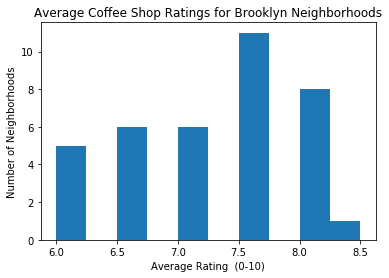

In [96]:
neighbor_bins = neighbor_ratings.copy()

bins =  [6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0]
labels =  [6.0, 6.5, 7.0, 7.5, 8.0, 8.5]

neighbor_bins['rating_bin'] = pd.cut(neighbor_bins['avg_rating'], bins=bins, labels=labels, include_lowest=True)
neighbor_bins['rating_bin'] = neighbor_bins['rating_bin'].astype('float')

neighbor_bins['rating_bin'].plot(kind='hist')

plt.title('Average Coffee Shop Ratings for Brooklyn Neighborhoods') # add a title to the histogram
plt.ylabel('Number of Neighborhoods') # add y-label
plt.xlabel('Average Rating  (0-10)') # add x-label

plt.show()

In [97]:
neighbor_bins['rating_bin'].value_counts()

7.5    11
8.0     8
6.5     6
7.0     6
6.0     5
8.5     1
Name: rating_bin, dtype: int64

### For the highest quality tour, we might to choose ratings of at least 8, but let's look at the map. ###
#### Red = 'High'&nbsp;&nbsp;&nbsp;Orange = 'Medium'&nbsp;&nbsp;&nbsp; Yellow = 'Low' ####

In [124]:
#!conda install -c conda-forge folium=0.5.0 --yes
import folium

# lat, lon for Brooklyn
latitude = 40.6469828
longitude = -73.9429487

colordict = {6.0: 'yellow', 6.5: 'yellow', 7.0: 'orange', 7.5:'orange', 8.0:'red', 8.5:'red' }

ratings_map = folium.Map(location=[latitude, longitude], 
                         zoom_start=12,
                         width='65%', height='100%', left='0%',)



for nh,lat,lng,nbin,in zip(neighbor_bins['Name'],neighbor_bins['lat'],neighbor_bins['lng'],neighbor_bins['rating_bin']): 
    # Marker() takes location coordinates  
    # as a list as an argument 
    folium.CircleMarker(
        location=[lat,lng],
        fill_color=colordict[nbin],
        fill=True,
        fill_opacity= 1,
        color = 'grey',
        radius = 6,
        width = 1,
        popup = (str(nh) + '<br>' + 'Avg Rating ' + str(nbin))
    ).add_to(ratings_map)
    
# display the map of San Francisco  (use static image for this report)
#ratings_map

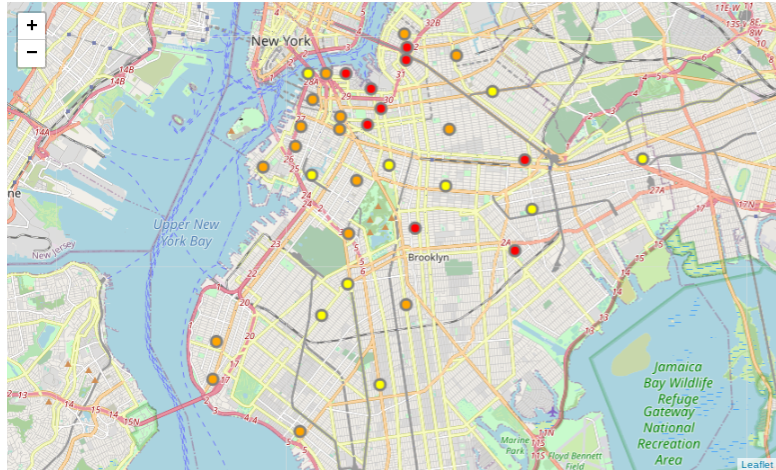

### Obervations ###
Without doing any formal cluster analysis, we can see that the 'High' rated coffee neighborhoods are located in the north part of Brooklyn; the 'Medium' neighborhoods in the northwest and west; 'Low" scattered around the borough.

### Limitations of the Analysis ###

The scope of the analysis was to use Foursquare venue data, but there are some limitations to what data can be retrieved.  <p>
As for the geography of the search, we selected the centroid for each neighborhoo.  Foursquare only allows the sselected venues within a certain radius (500 m), which does not match the geographies of the neighborhoods.  A much better approach would be to assign a neighborhood name to each venue directly, either by a geocoding service or a GIS spatial overlay.<p>
As one would imagine, the quality of the search data has many caveats.  Customer ratigs are notoriously fickle, especially with the very high and very low ratings, and many venues have no ratings yet. Ratings might be weighted with the number of 'likes', but this was not explored here. The 'coffee' venues are identified only by a keyword search of the descriptions, with no other details.

### Conclusions and Recommendation ###

Using data provided by Foursquare and 'coffee tourism' neighborhoods in Brooklyn were ranked by the average customer rating.  Despite some issues, our broad qualatative analysis shows that the best areas to hold tours would be in the north/northwest section of Brooklyn, which has almost all the 'high' ratings and many of the 'medium' ratings. <p>
If this project is succesful, this analysis can be applied to the other four boroughs to identify tour locations there.